In [1]:
!pip install mlxtend -qq

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor, LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, cross_val_score, train_test_split

%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.6f}'.format

In [4]:
#load the dataset
from google.colab import files
iploaded=files.upload()

Saving CO2PROJECT.csv to CO2PROJECT.csv


In [8]:
data = pd.read_csv('CO2PROJECT.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   make                            7385 non-null   object 
 1   model                           7385 non-null   object 
 2   vehicle_class                   7385 non-null   object 
 3   engine_size                     7385 non-null   float64
 4   cylinders                       7385 non-null   int64  
 5   transmission                    7385 non-null   object 
 6   fuel_type                       7385 non-null   object 
 7   fuel_consumption_city           7385 non-null   float64
 8   fuel_consumption_hwy            7385 non-null   float64
 9   fuel_consumption_comb(l/100km)  7385 non-null   float64
 10  fuel_consumption_comb(mpg)      7385 non-null   int64  
 11  co2_emissions                   7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)

# Exploratory Data Analysis

 Preparing the Dataset

In [10]:
# rename the colum

In [11]:
data = data.rename(columns={
    'Vehicle Class': 'Vehicle_Class',
    'Engine Size(L)': 'Engine_Size',
    'Fuel Type': 'Fuel_Type',
    'Fuel Consumption City (L/100 km)': 'Fuel_Consumption_City',
    'Fuel Consumption Hwy (L/100 km)': 'Fuel_Consumption_Hwy',
    'Fuel Consumption Comb (L/100 km)': 'Fuel_Consumption_Comb',
    'Fuel Consumption Comb (mpg)': 'Fuel_Consumption_Comb1',
    'CO2 Emissions(g/km)': 'CO2_Emissions'
})

In [12]:
#Data dimensions

In [13]:
data.shape

(7385, 12)

In [14]:
data.dtypes

make                               object
model                              object
vehicle_class                      object
engine_size                       float64
cylinders                           int64
transmission                       object
fuel_type                          object
fuel_consumption_city             float64
fuel_consumption_hwy              float64
fuel_consumption_comb(l/100km)    float64
fuel_consumption_comb(mpg)          int64
co2_emissions                       int64
dtype: object

In [15]:
missing_value = pd.DataFrame({
    'Missing Value': data.isnull().sum(),
    'Percentage': (data.isnull().sum() / len(data))*100
})

In [16]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
make,0,0.000000
model,0,0.000000
vehicle_class,0,0.000000
engine_size,0,0.000000
cylinders,0,0.000000
transmission,0,0.000000
fuel_type,0,0.000000
fuel_consumption_city,0,0.000000
fuel_consumption_hwy,0,0.000000
fuel_consumption_comb(l/100km),0,0.000000


In [17]:
duplicate = data.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 1113 duplicated rows in the data


In [18]:
data.drop_duplicates(inplace=True)

In [19]:
data.reset_index(inplace=True, drop=True)

In [20]:
#data understanding

In [21]:
data.describe(include=np.number)

,engine_size,cylinders,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb(l/100km),fuel_consumption_comb(mpg),co2_emissions
count,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000,6272.000000
mean,3.163122,5.620855,12.616055,9.073645,11.022465,27.394292,251.254464
std,1.365369,1.846458,3.550664,2.278008,2.945130,7.225814,59.237363
min,0.900000,3.000000,4.200000,4.000000,4.100000,11.000000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,22.000000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,27.000000,246.000000
75%,3.700000,6.000000,14.700000,10.300000,12.700000,32.000000,289.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,69.000000,522.000000


In [22]:
data.describe(include = object)

,make,model,vehicle_class,transmission,fuel_type
count,6272,6272,6272,6272,6272
unique,42,2048,16,5,5
top,FORD,F-150 FFV,SUV - SMALL,AS,X
freq,575,32,1003,2720,3029


In [23]:
#correlation

In [24]:
data_num_features = data.select_dtypes(include=np.number)

print('The numerical columns in the dataset are: ',data_num_features.columns)

The numerical columns in the dataset are:  Index(['engine_size', 'cylinders', 'fuel_consumption_city',
       'fuel_consumption_hwy', 'fuel_consumption_comb(l/100km)',
       'fuel_consumption_comb(mpg)', 'co2_emissions'],
      dtype='object')


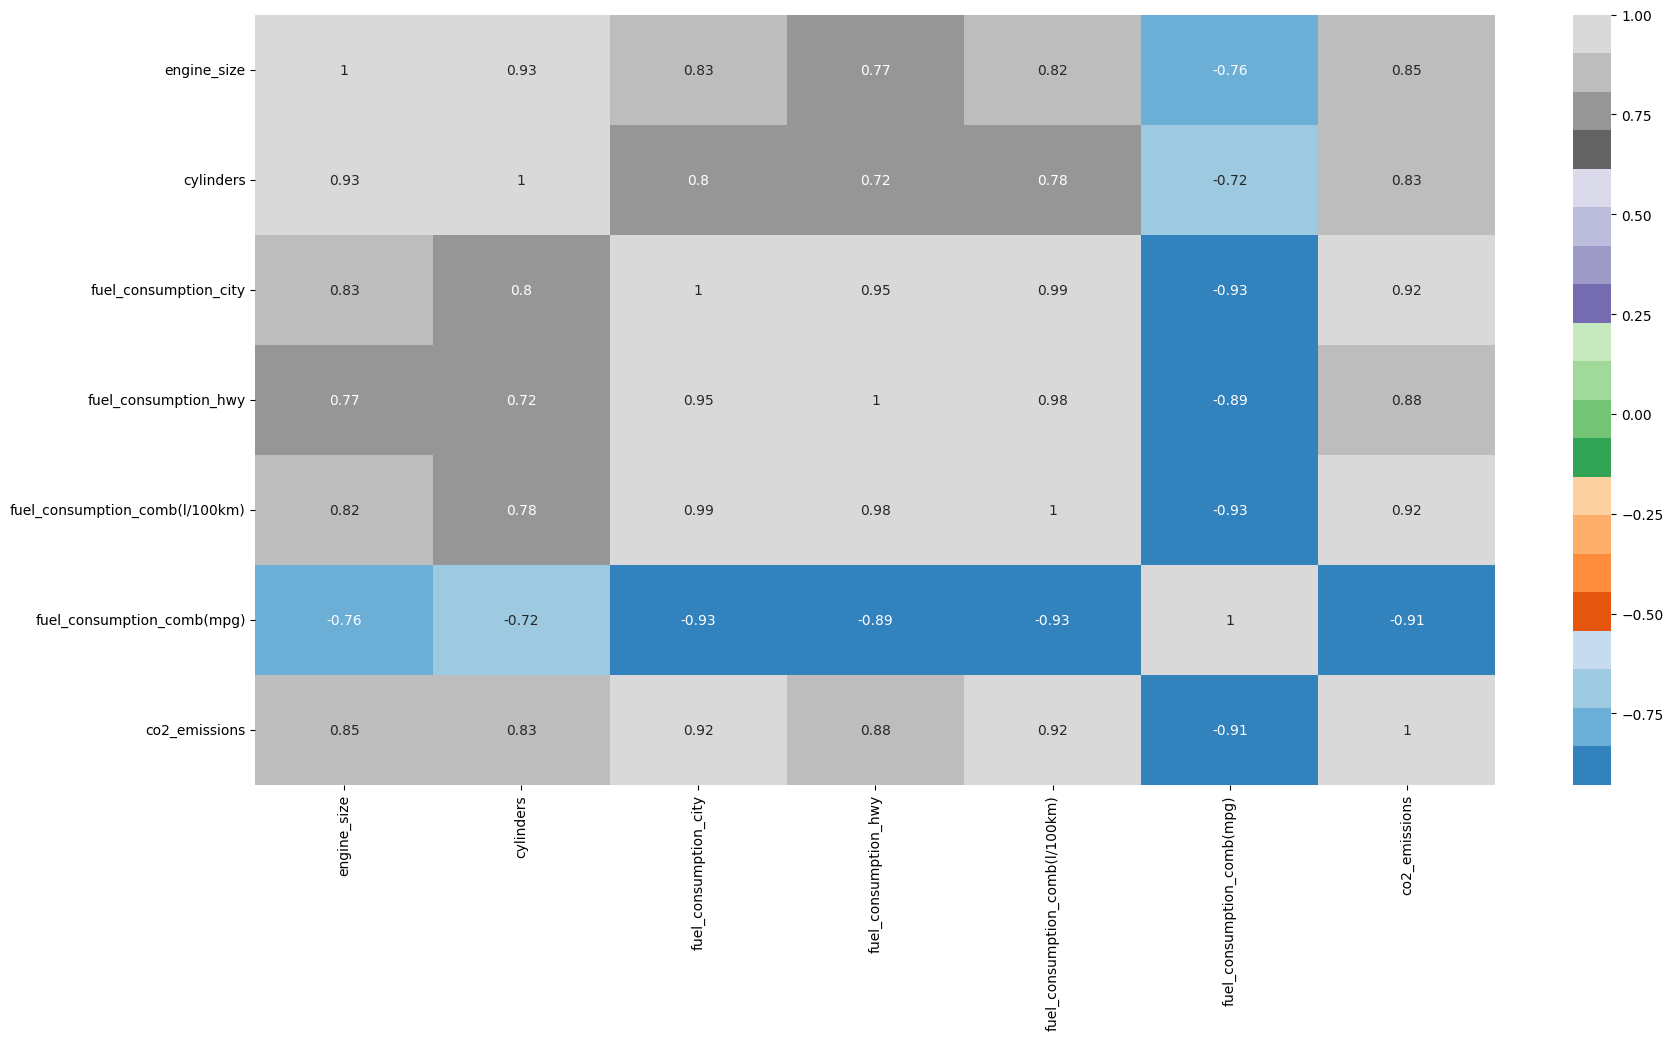

In [25]:
plt.figure(figsize=(20,10))

corr =  data_num_features.corr()

corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20c')
plt.show()

In [28]:
#analyse categorical variables?

In [31]:
data_cat_features.head()

,make,model,vehicle_class,transmission,fuel_type
0,ACURA,ILX,COMPACT,AS,Z
1,ACURA,ILX,COMPACT,M,Z
2,ACURA,ILX HYBRID,COMPACT,AV,Z
3,ACURA,MDX 4WD,SUV - SMALL,AS,Z
4,ACURA,RDX AWD,SUV - SMALL,AS,Z


In [34]:
data_cat_features = data.select_dtypes(include='object')
data_cat_features1 = data_cat_features[['vehicle_class', 'transmission', 'fuel_type', 'model','make']]

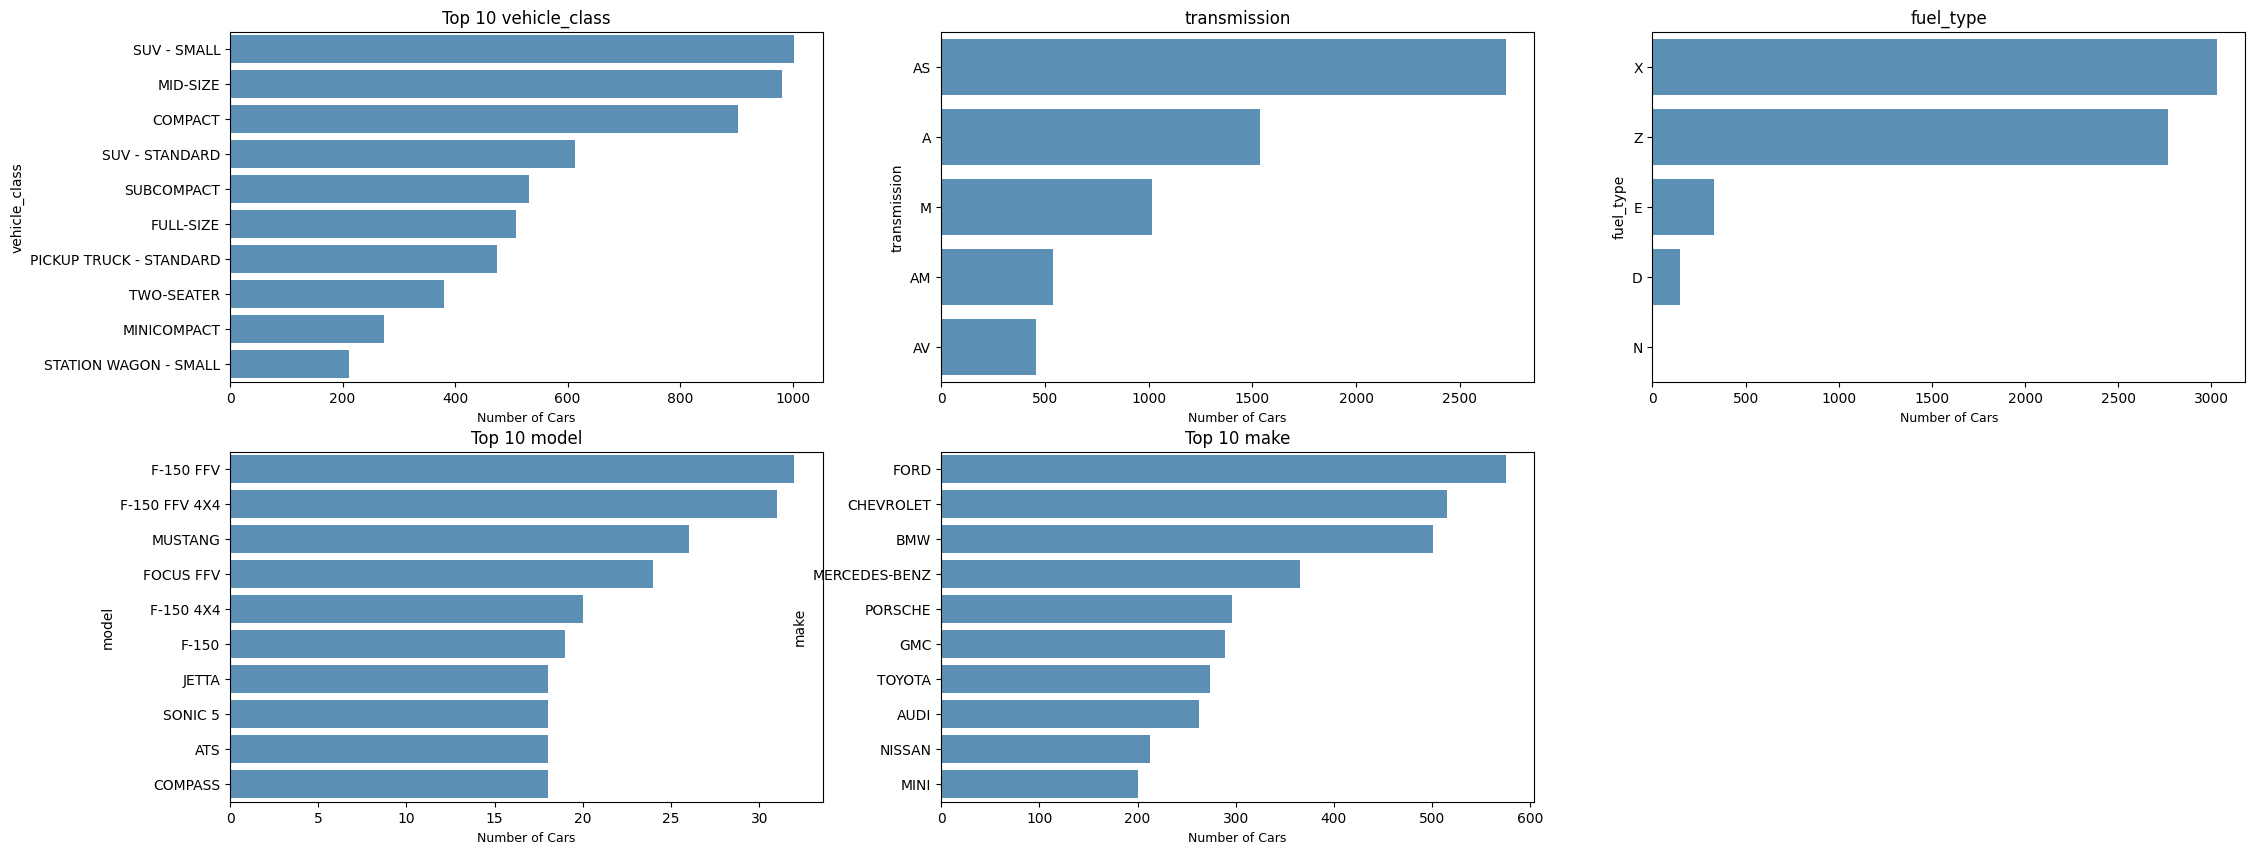

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(26, 10))

for variable, subplot in zip(data_cat_features1.columns, ax.flatten()):
    cat_count  = data[variable].value_counts()
    cat_count10 = cat_count[:10]
    z = sns.barplot(x=cat_count10.values, y=cat_count10.index, alpha=0.8, ax=subplot)
    if cat_count.size > 10:
        z.set_title('Top 10 {}'.format(variable))
    else:
        z.set_title(variable)
    z.set_xlabel('Number of Cars', fontsize=9)

fig.delaxes(ax[1][2])


In [41]:
#Analyse target variable

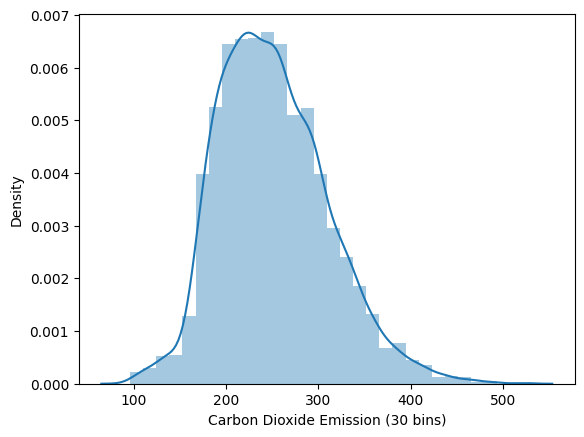

In [43]:
sns.distplot(data['co2_emissions'], bins=30, kde=True, axlabel='Carbon Dioxide Emission (30 bins)')
plt.show()

In [45]:
mean = data['co2_emissions'].mean()
mode = data['co2_emissions'].mode()
median = data['co2_emissions'].median()

print(f'Mean for CO2 Emission is {mean}')
print(f'Median for CO2 Emission is {median}')
print(f'Mode for CO2 Emission is {mode}')

Mean for CO2 Emission is 251.25446428571428
Median for CO2 Emission is 246.0
Mode for CO2 Emission is 0    221
1    246
Name: co2_emissions, dtype: int64


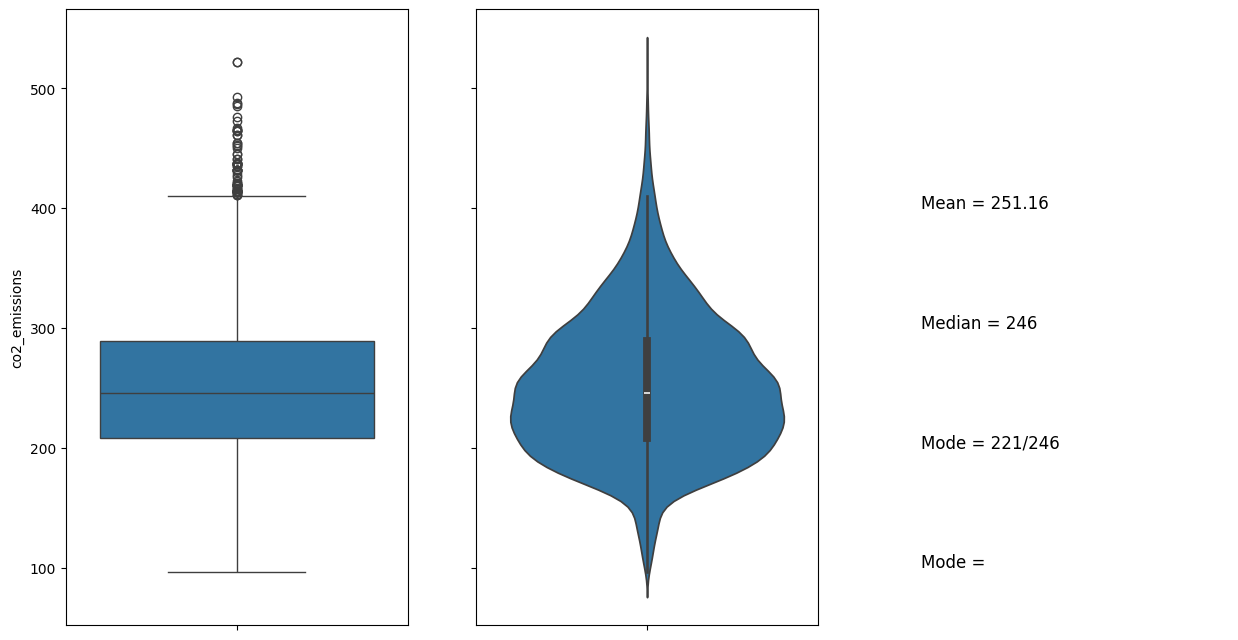

In [49]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 8))
sns.boxplot(y=data['co2_emissions'], orient="v", ax=axes[0])
sns.violinplot(y=data['co2_emissions'], orient="v", ax=axes[1])
plt.text(0.1, 200, "Mode = 221/246", fontsize=12)
plt.text(0.1, 300, "Median = 246", fontsize=12)
plt.text(0.1, 400, "Mean = 251.16", fontsize=12)
plt.text(0.1, 100, "Mode = ", fontsize=12)
plt.axis("off")
plt.show()

In [50]:
#analyse relationship between target and independent variable

In [54]:
make_co2 = data.groupby('make')['co2_emissions'].mean().sort_values(ascending=False).head(10)
model_co2 = data.groupby('model')['co2_emissions'].mean().sort_values(ascending=False).head(10)
vehicle_class_co2 = data.groupby('vehicle_class')['co2_emissions'].mean().sort_values(ascending=False).head(10)
transmission_co2 = data.groupby('transmission')['co2_emissions'].mean().sort_values(ascending=False).head(10)
fuel_type_co2 = data.groupby('fuel_type')['co2_emissions'].mean().sort_values(ascending=False).head()

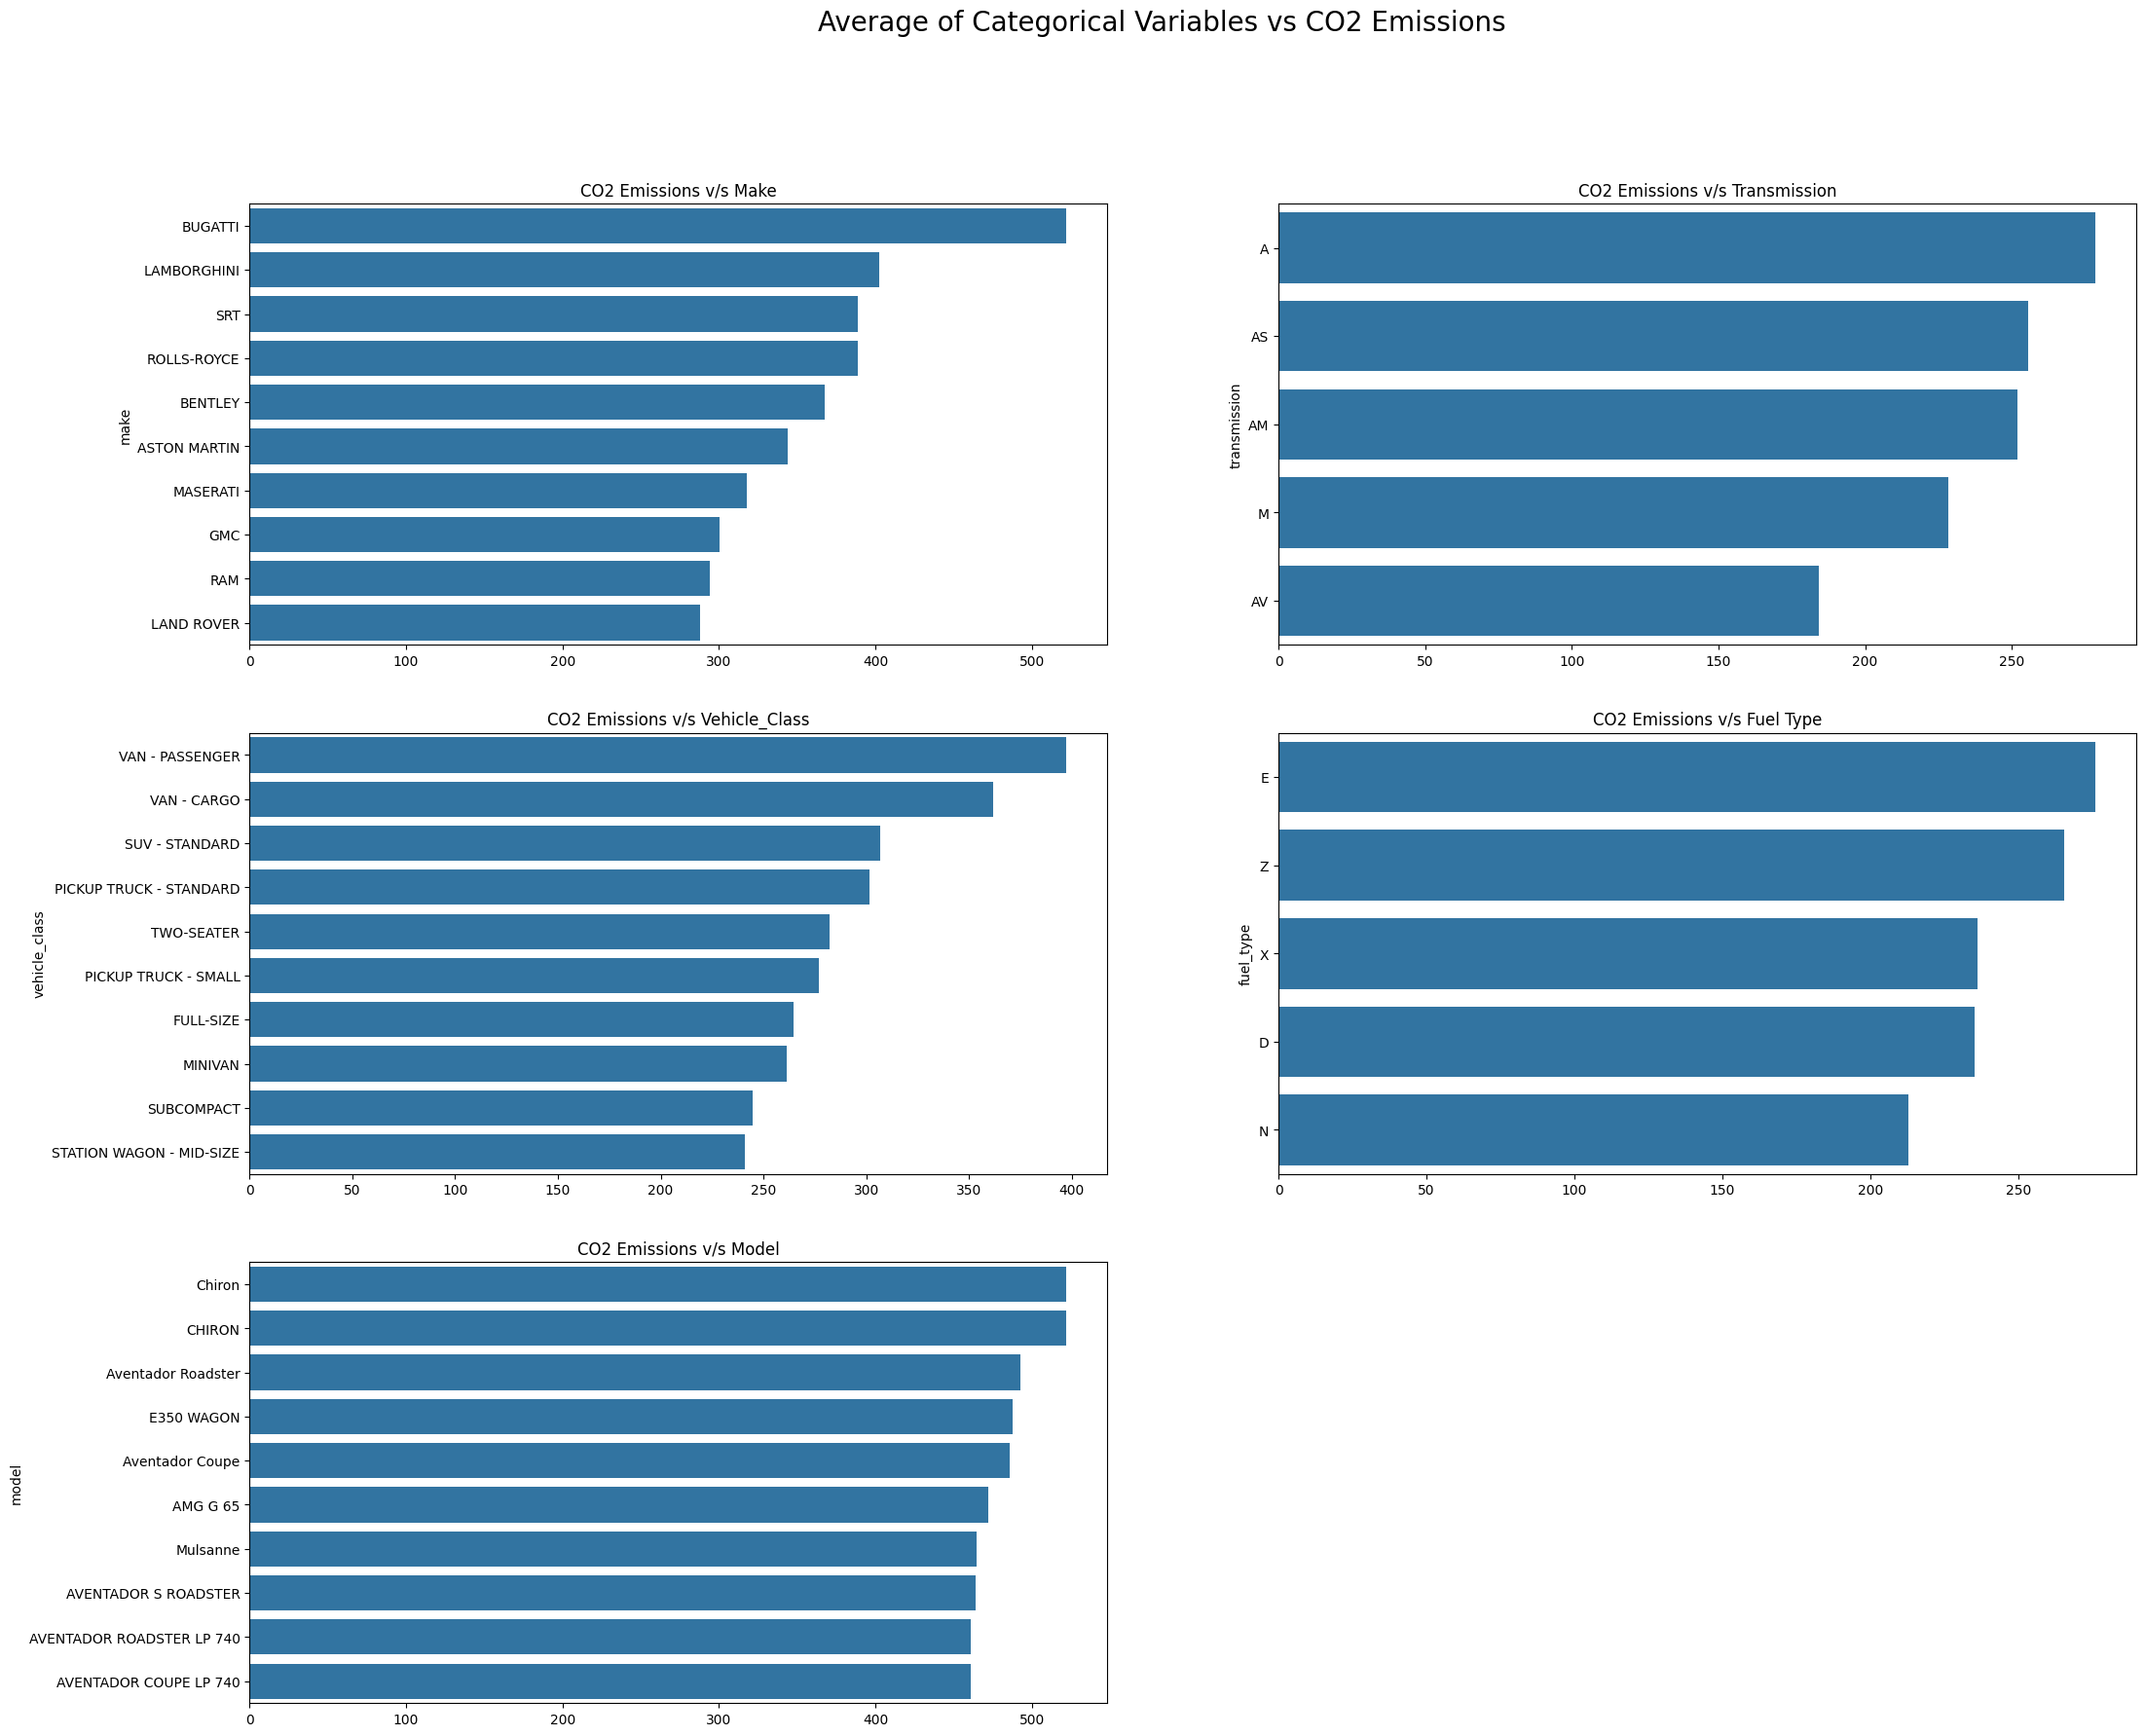

In [55]:
fig, axes = plt.subplots(3,2, figsize=(25,20))
fig.suptitle('Average of Categorical Variables vs CO2 Emissions', size=20)

sns.barplot(ax=axes[0][0],x = make_co2.values,y = make_co2.index)
axes[0][0].set_title('CO2 Emissions v/s Make')

sns.barplot(ax=axes[0][1],x = transmission_co2.values,y = transmission_co2.index)
axes[0][1].set_title('CO2 Emissions v/s Transmission')

sns.barplot(ax=axes[1][0],x = vehicle_class_co2.values,y = vehicle_class_co2.index)
axes[1][0].set_title('CO2 Emissions v/s Vehicle_Class')

sns.barplot(ax=axes[1][1], x=fuel_type_co2.values,y=fuel_type_co2.index)
axes[1][1].set_title('CO2 Emissions v/s Fuel Type')

sns.barplot(ax=axes[2][0],x = model_co2.values,y = model_co2.index)
axes[2][0].set_title('CO2 Emissions v/s Model')


fig.delaxes(axes[2][1])
plt.show()

In [56]:
#relationship between cylinders and co2 emission

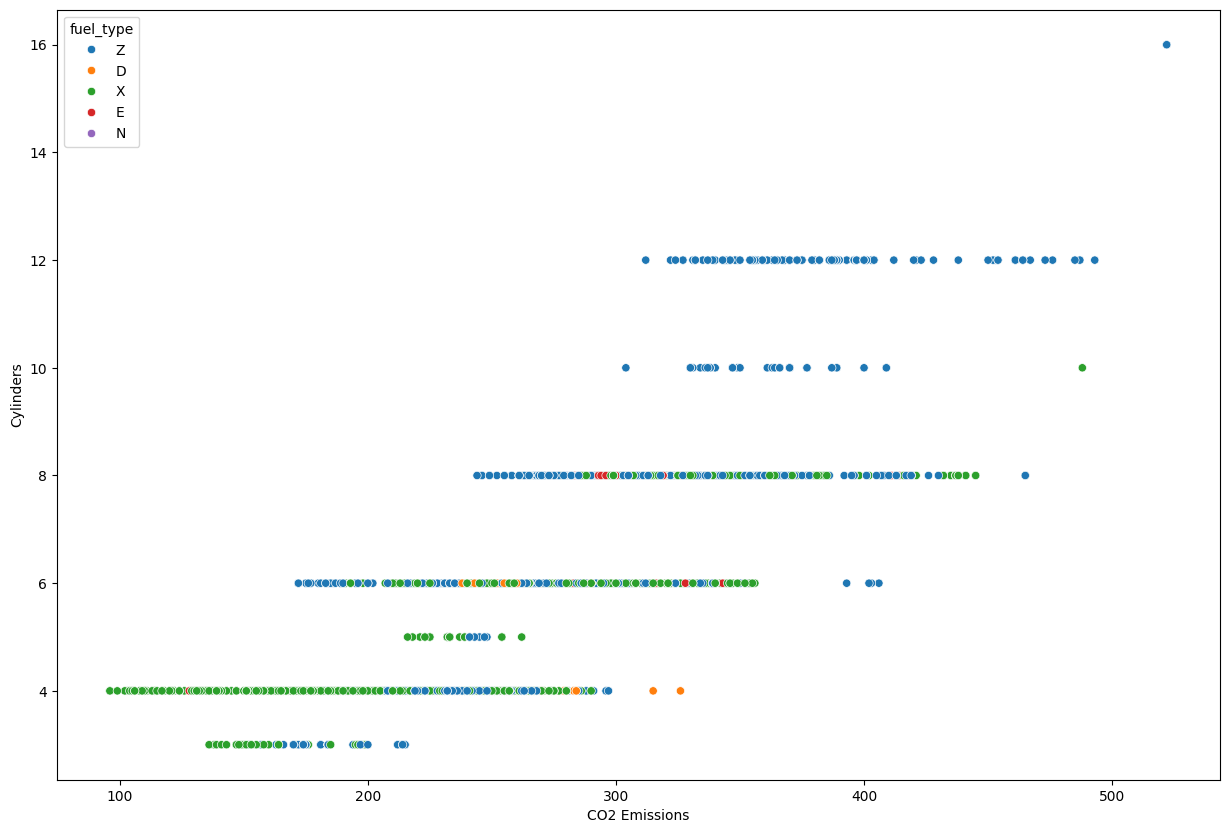

In [68]:
plt.rcParams["figure.figsize"] = (15,10)
sns.scatterplot(x='co2_emissions',y='cylinders',data = data , hue='fuel_type')
plt.xlabel("CO2 Emissions", fontsize=10)
plt.ylabel("Cylinders", fontsize=10)
plt.show()

In [69]:
#Feature engineering

In [71]:
data['Make_Type'] = data['make'].replace(['BUGATTI', 'PORSCHE', 'MASERATI', 'ASTON MARTIN', 'LAMBORGHINI', 'JAGUAR','SRT'], 'Sports')
data['Make_Type'] = data['Make_Type'].replace(['ALFA ROMEO', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHRYSLER', 'DODGE', 'GMC','INFINITI', 'JEEP', 'LAND ROVER', 'LEXUS', 'MERCEDES-BENZ','MINI', 'SMART', 'VOLVO'],'Premium')
data['Make_Type'] = data['Make_Type'].replace(['ACURA', 'BENTLEY', 'LINCOLN', 'ROLLS-ROYCE',  'GENESIS'], 'Luxury')
data['Make_Type'] = data['Make_Type'].replace(['CHEVROLET', 'FIAT', 'FORD', 'KIA', 'HONDA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI','NISSAN', 'RAM', 'SCION', 'SUBARU', 'TOYOTA','VOLKSWAGEN'],'General')

In [73]:
data.drop(['make'], inplace=True, axis=1)

data['Make_Type'].unique()

array(['Luxury', 'Premium', 'Sports', 'General'], dtype=object)

In [74]:
data['Make_Type'].value_counts()

Make_Type
General    2766
Premium    2731
Sports      546
Luxury      229
Name: count, dtype: int64

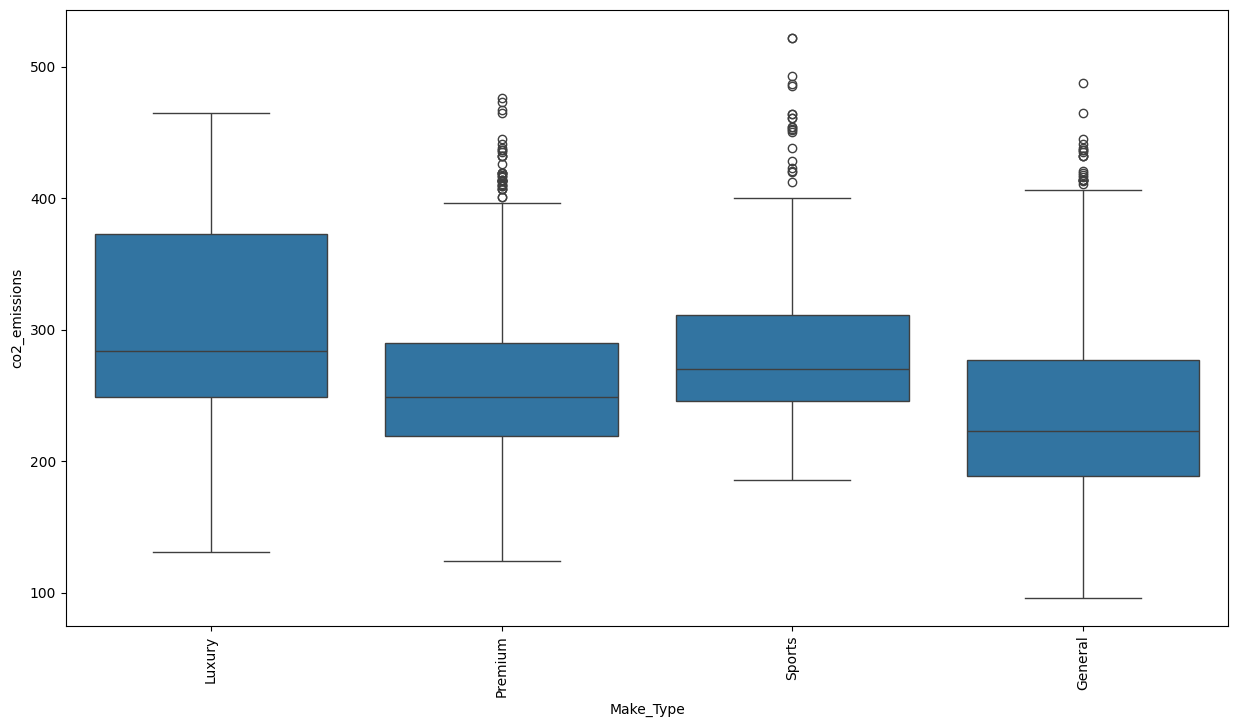

In [76]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Make_Type", y="co2_emissions", data=data)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

In [78]:
data['Vehicle_Class_Type'] = data['vehicle_class'].replace(['COMPACT', 'MINICOMPACT', 'SUBCOMPACT'], 'Hatchback')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['MID-SIZE', 'TWO-SEATER', 'FULL-SIZE', 'STATION WAGON - SMALL', 'STATION WAGON - MID-SIZE'],'Sedan')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['SUV - SMALL', 'SUV - STANDARD', 'MINIVAN'],  'SUV')
data['Vehicle_Class_Type'] = data['Vehicle_Class_Type'].replace(['VAN - CARGO', 'VAN - PASSENGER', 'PICKUP TRUCK - STANDARD', 'SPECIAL PURPOSE VEHICLE', 'PICKUP TRUCK - SMALL'], 'Truck')

In [80]:
data.drop(['vehicle_class'], inplace=True,  axis=1)

data['Vehicle_Class_Type'].unique()

array(['Hatchback', 'SUV', 'Sedan', 'Truck'], dtype=object)

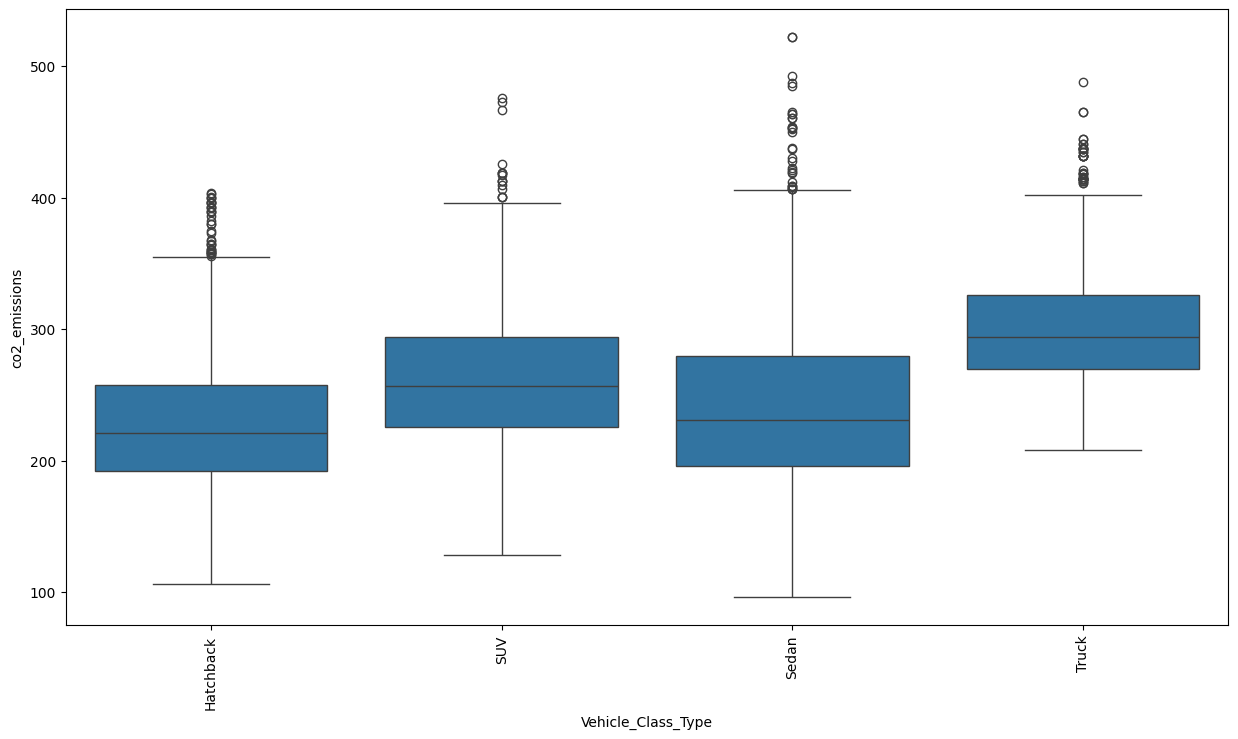

In [82]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Vehicle_Class_Type", y="co2_emissions", data=data)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

In [84]:
#data preprocessing


#DROPING MODEL

In [86]:
data.drop(['model'],axis=1,inplace=True)

In [87]:
# Outliers
# Discovery of Outliers

In [88]:
df_num_features=data.select_dtypes(include=np.number)

In [89]:
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

engine_size                       1.700000
cylinders                         2.000000
fuel_consumption_city             4.600000
fuel_consumption_hwy              2.800000
fuel_consumption_comb(l/100km)    3.800000
fuel_consumption_comb(mpg)       10.000000
co2_emissions                    81.000000
dtype: float64


In [90]:
outlier = pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column engine_size are 121
Total number of Outliers in column cylinders are 177
Total number of Outliers in column fuel_consumption_city are 116
Total number of Outliers in column fuel_consumption_hwy are 150
Total number of Outliers in column fuel_consumption_comb(l/100km) are 115
Total number of Outliers in column fuel_consumption_comb(mpg) are 93
Total number of Outliers in column co2_emissions are 74


In [91]:
#visualizing outliers using BOXplot

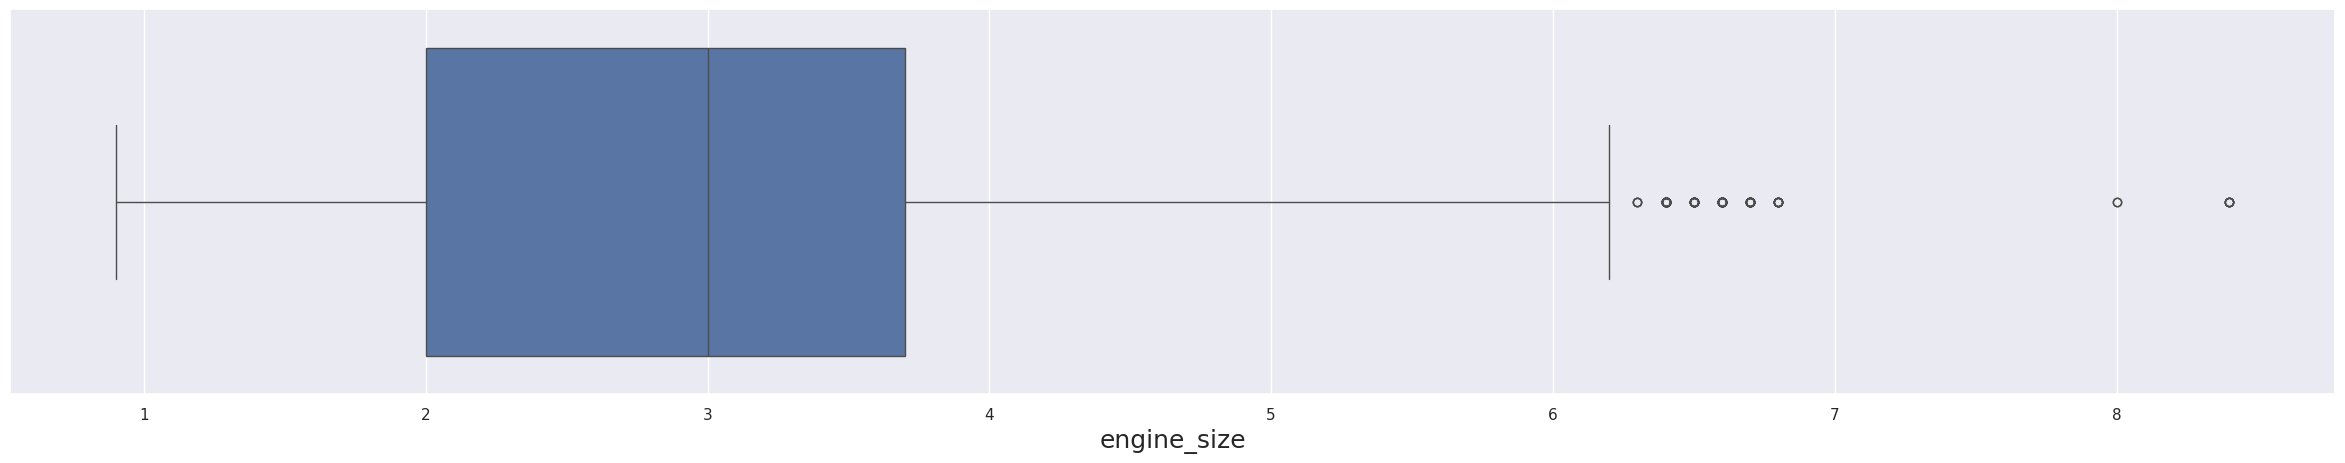

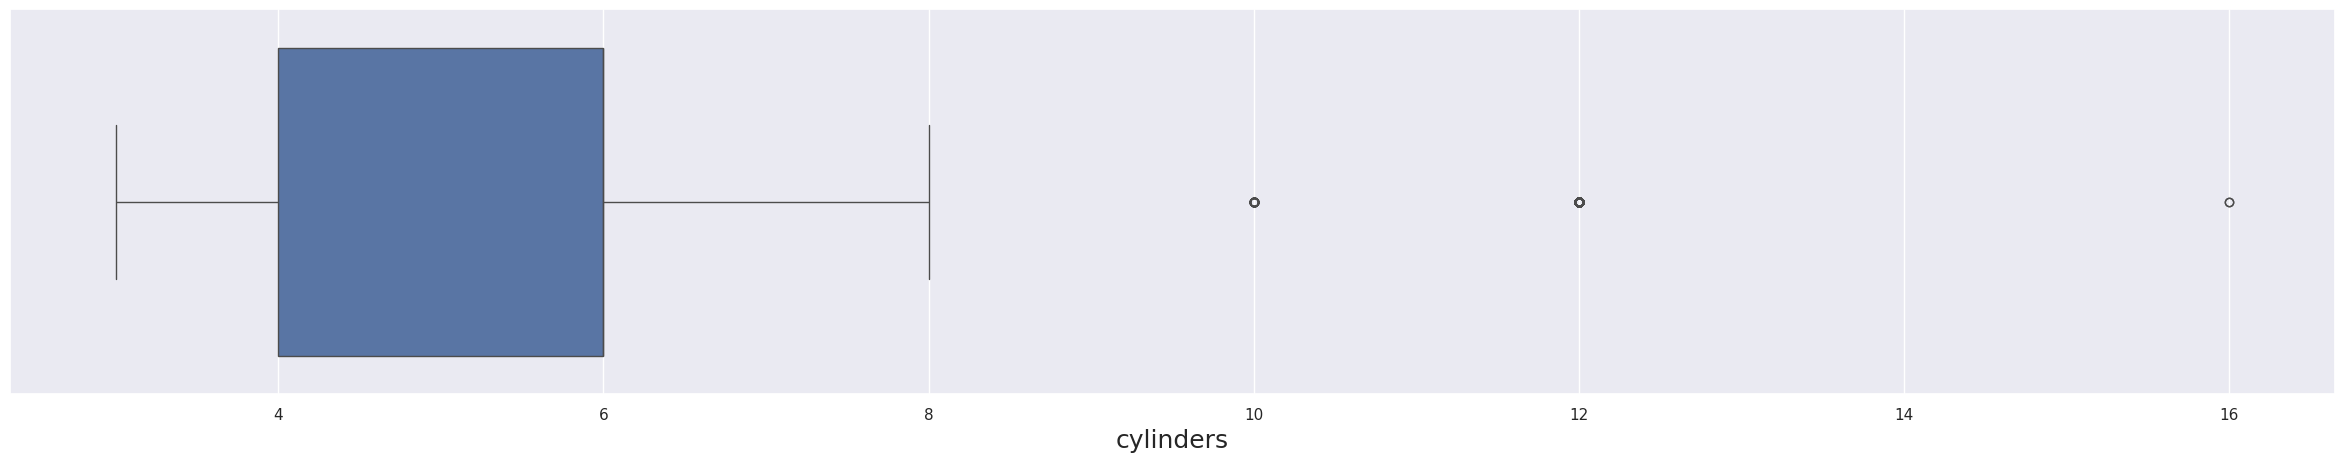

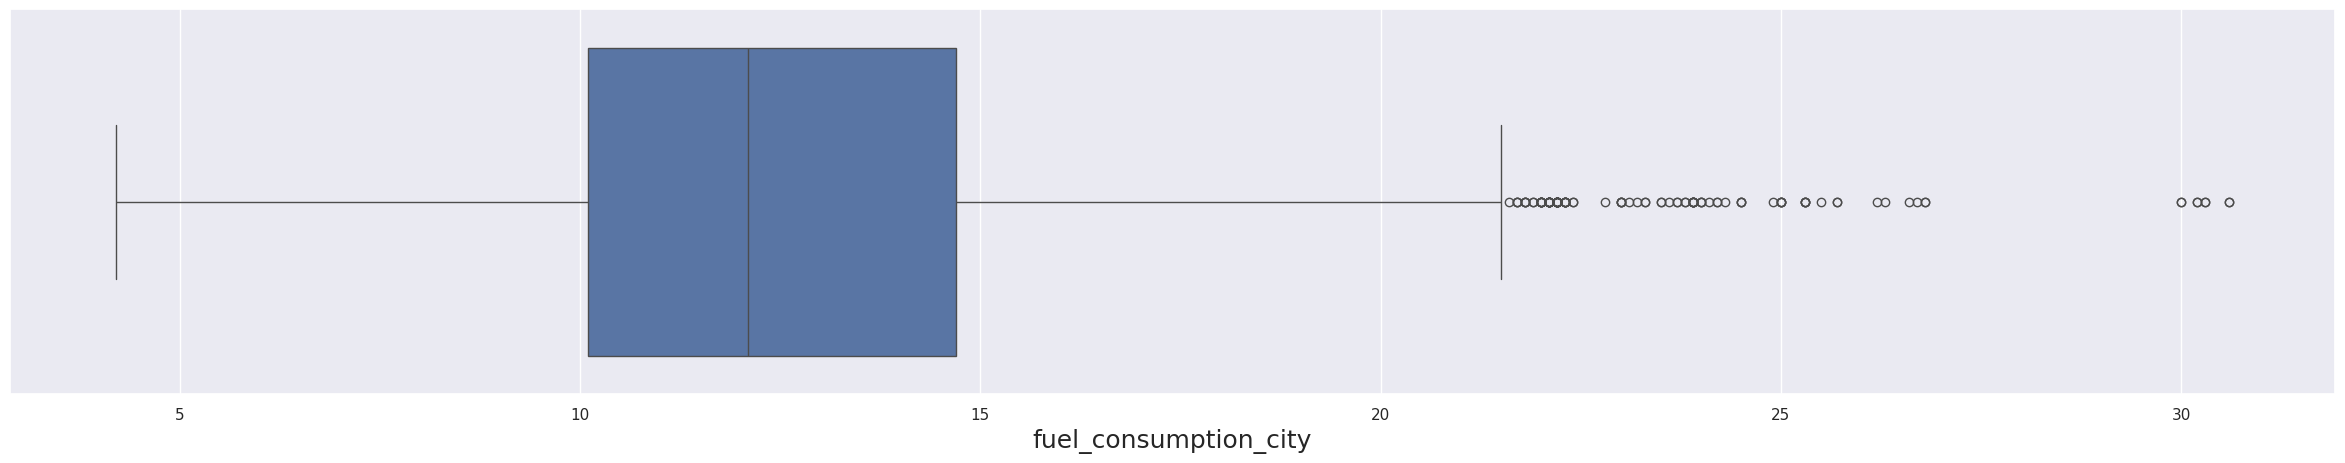

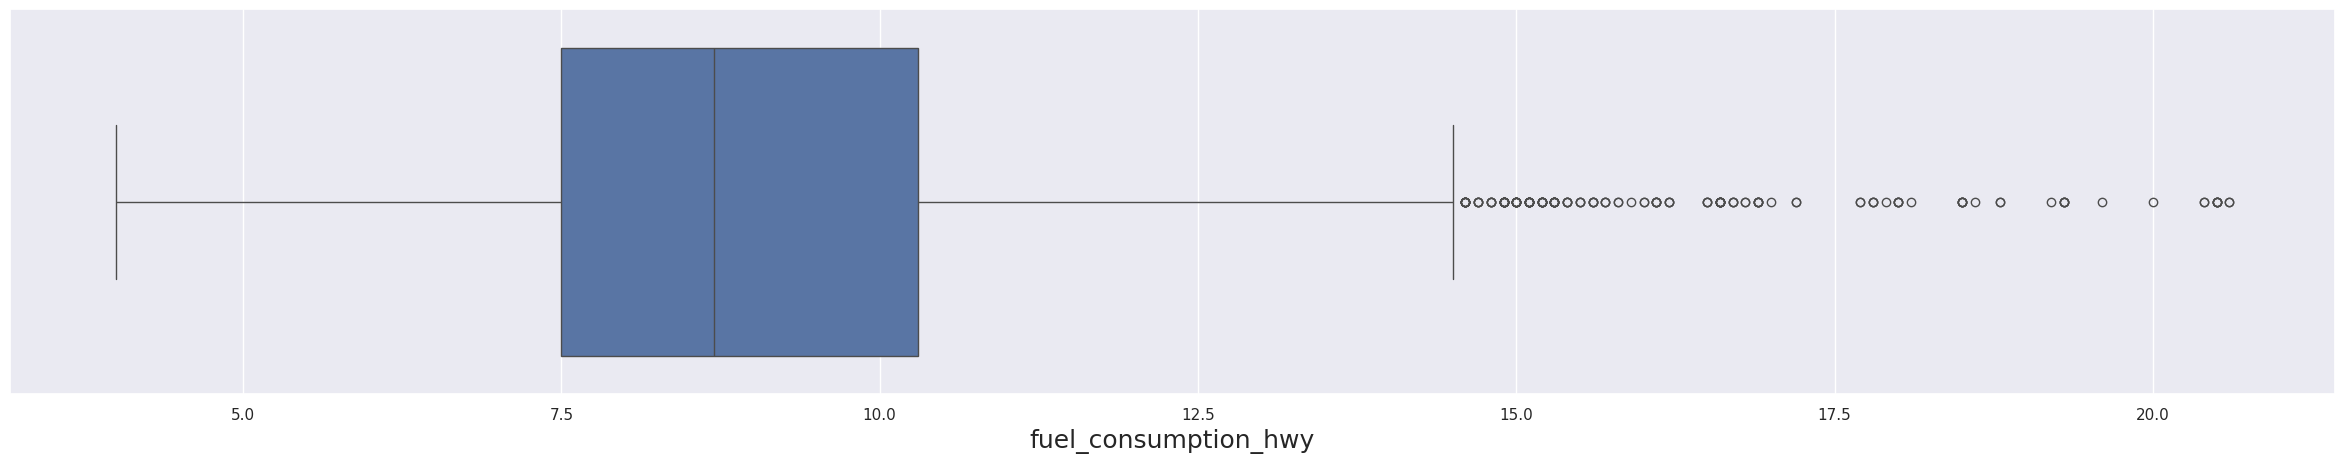

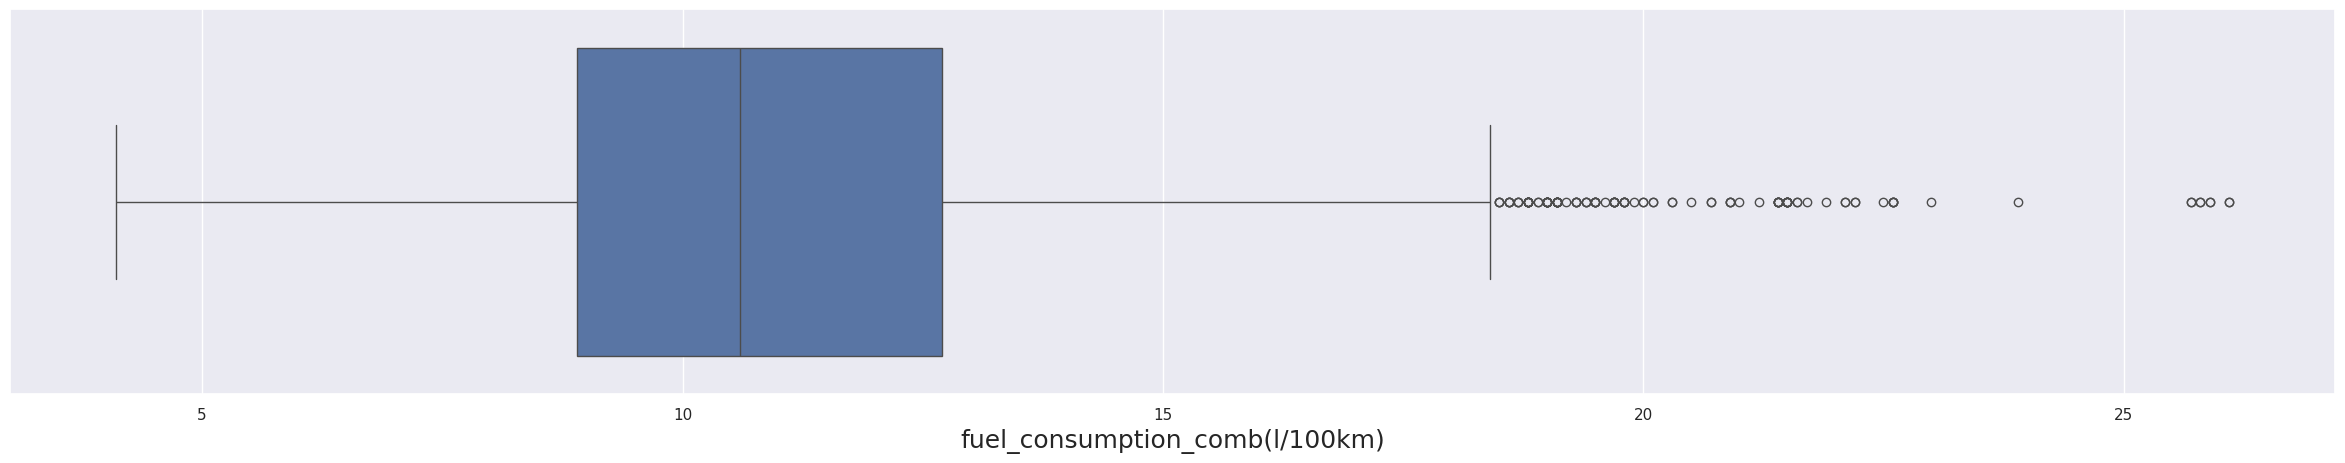

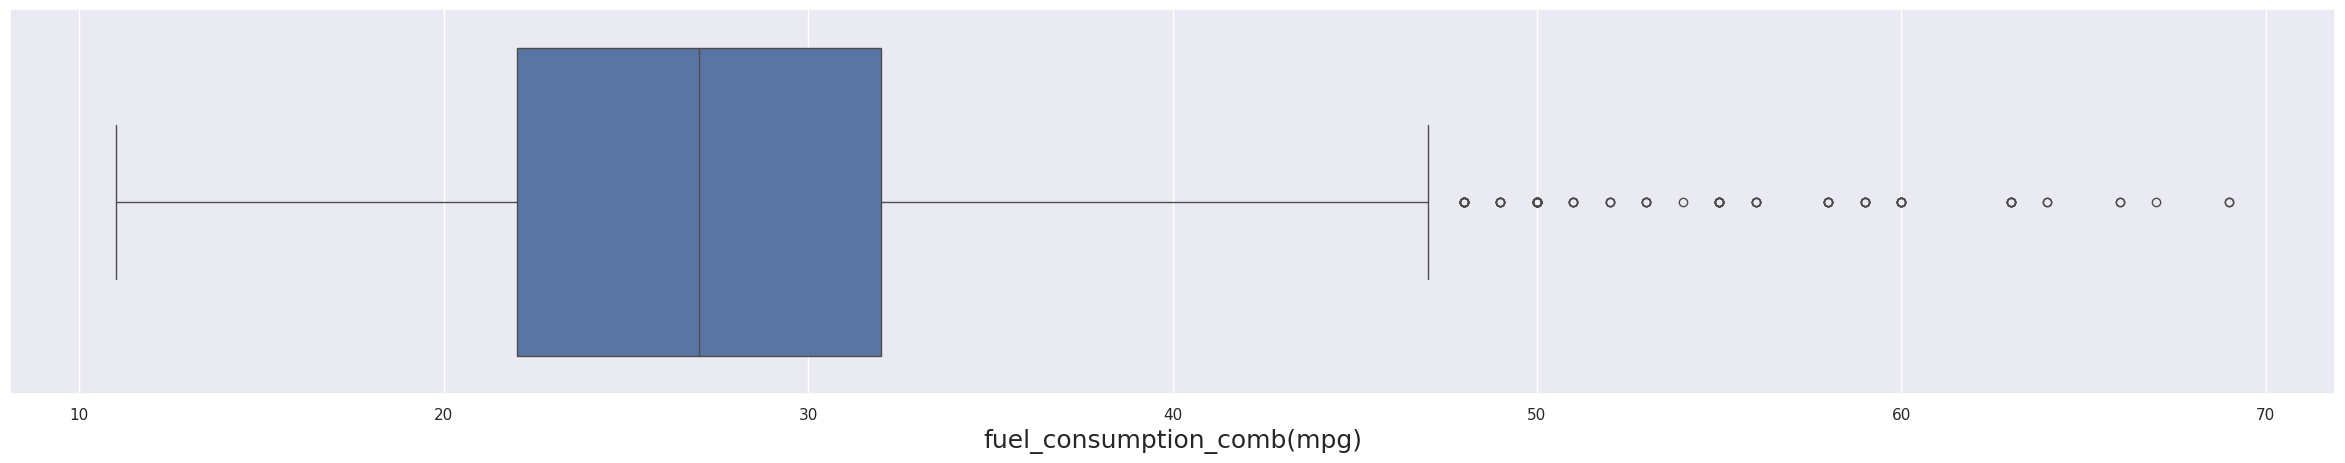

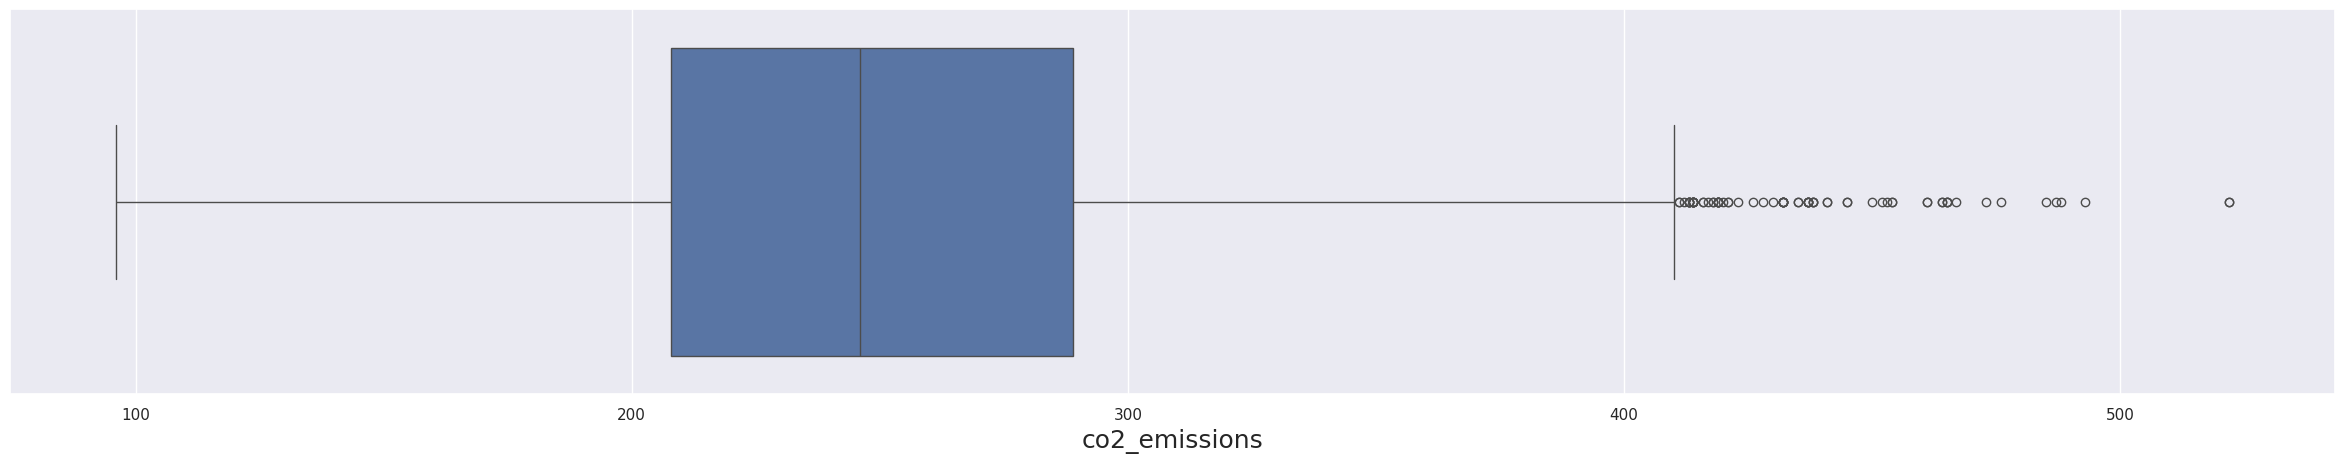

In [92]:
for column in enumerate(df_num_features):
    plt.figure(figsize=(30,5))
    sns.set_theme(style="darkgrid")
    sns.boxplot(x=column[1], data=  df_num_features)
    plt.xlabel(column[1],fontsize=18)
    plt.show()

In [93]:
#Removal of Outliers

#Checking the normality of numeric features

In [94]:
stat, p_value = shapiro(df_num_features)

print('Test statistic:', stat)
print('P-Value:', p_value)

Test statistic: 0.5184483528137207
P-Value: 0.0


In [101]:
# remove the outliers using IQR methord

def remove_outliers_iqr(df, columns):
  for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df

# Remove outliers using IQR method
data = remove_outliers_iqr(data, df_num_features.columns)

In [102]:
#reching correlation

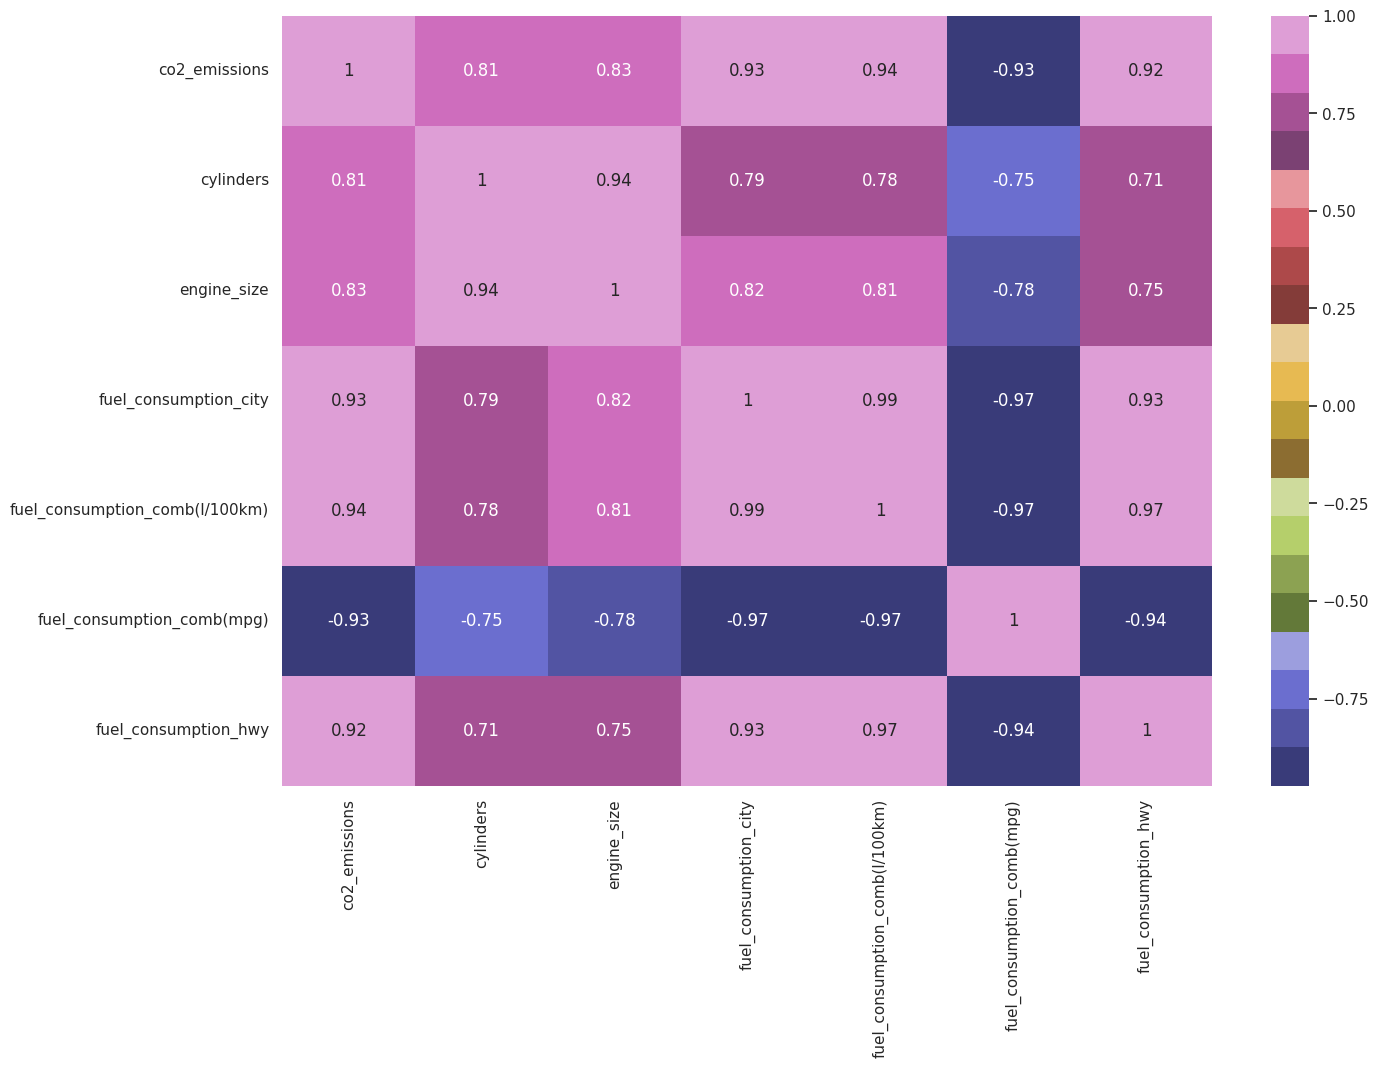

In [103]:
data_num_features = data.select_dtypes(include=np.number)

corr =  data_num_features.corr()

corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20b')
plt.show()

In [104]:
#categorical encoding

In [106]:
df_dummies = pd.get_dummies(data = data[["fuel_type","transmission","Make_Type","Vehicle_Class_Type"]], drop_first = True)

df_num_features=data.select_dtypes(include=np.number)

df_comb = pd.concat([df_num_features, df_dummies], axis = 1)

In [107]:
df_comb.head()

,co2_emissions,cylinders,engine_size,fuel_consumption_city,fuel_consumption_comb(l/100km),fuel_consumption_comb(mpg),fuel_consumption_hwy,fuel_type_E,fuel_type_N,fuel_type_X,fuel_type_Z,transmission_AM,transmission_AS,transmission_AV,transmission_M,Make_Type_Luxury,Make_Type_Premium,Make_Type_Sports,Vehicle_Class_Type_SUV,Vehicle_Class_Type_Sedan,Vehicle_Class_Type_Truck
0,196,4,2.000000,9.900000,8.500000,33,6.700000,False,False,False,True,False,True,False,False,True,False,False,False,False,False
1,221,4,2.000000,11.200000,9.600000,29,7.700000,False,False,False,True,False,False,False,True,True,False,False,False,False,False
3,255,6,3.500000,12.700000,11.100000,25,9.100000,False,False,False,True,False,True,False,False,True,False,False,True,False,False
4,244,6,3.500000,12.100000,10.600000,27,8.700000,False,False,False,True,False,True,False,False,True,False,False,True,False,False
5,230,6,3.500000,11.900000,10.000000,28,7.700000,False,False,False,True,False,True,False,False,True,False,False,False,True,False


In [279]:
#drop all object column

df = df.select_dtypes(exclude='object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   engine_size                     7385 non-null   float64
 1   cylinders                       7385 non-null   int64  
 2   fuel_consumption_city           7385 non-null   float64
 3   fuel_consumption_hwy            7385 non-null   float64
 4   fuel_consumption_comb(l/100km)  7385 non-null   float64
 5   fuel_consumption_comb(mpg)      7385 non-null   int64  
 6   co2_emissions                   7385 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 404.0 KB


In [280]:
#Multiple regression model

In [281]:
!pip install statsmodels
import statsmodels.api as sm

In [282]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [283]:
X = df_comb.drop(['co2_emissions'], axis=1)
y = df_comb['co2_emissions']

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [285]:
# Convert the input data to numeric type
X_train_numeric = X_train.astype(float)
y_train_numeric = y_train.astype(float)

# Fit the OLS model
MLR_model1 = sm.OLS(y_train_numeric, X_train_numeric).fit()

# Display the summary
print(MLR_model1.summary())


                                 OLS Regression Results                                
Dep. Variable:          co2_emissions   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.193e+05
Date:                Sat, 06 Apr 2024   Prob (F-statistic):                        0.00
Time:                        11:28:11   Log-Likelihood:                         -10359.
No. Observations:                3850   AIC:                                  2.076e+04
Df Residuals:                    3830   BIC:                                  2.088e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [286]:
# Logistic
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [287]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [288]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [289]:
#neural network

from sklearn.neural_network import MLPClassifier

# Create an MLP classifier with 3 layers and 100 neurons in each layer
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), activation='relu', solver='adam', max_iter=1000)

# Fit the model to the training data
mlp_model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)

In [290]:
#Auto correlation

In [291]:
import numpy as np
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

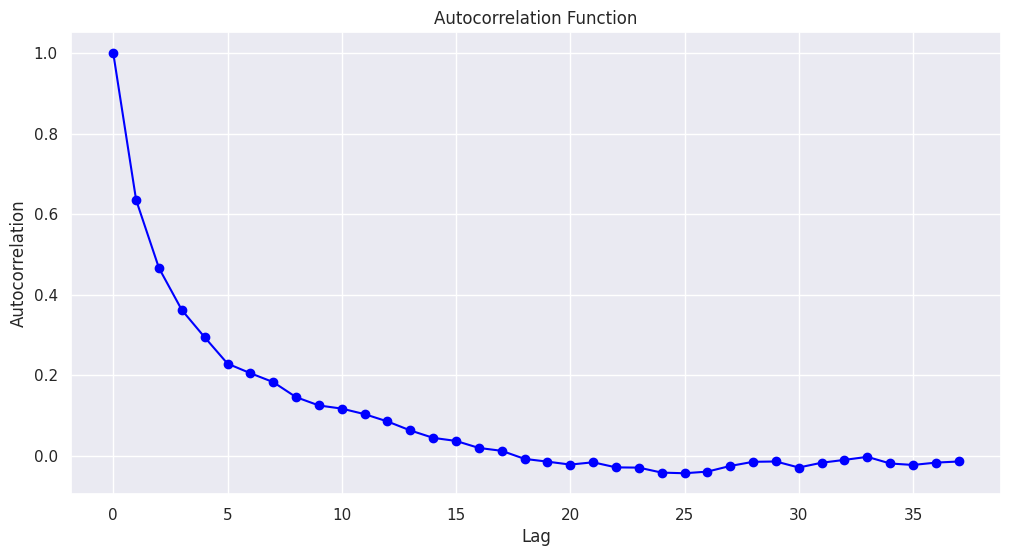

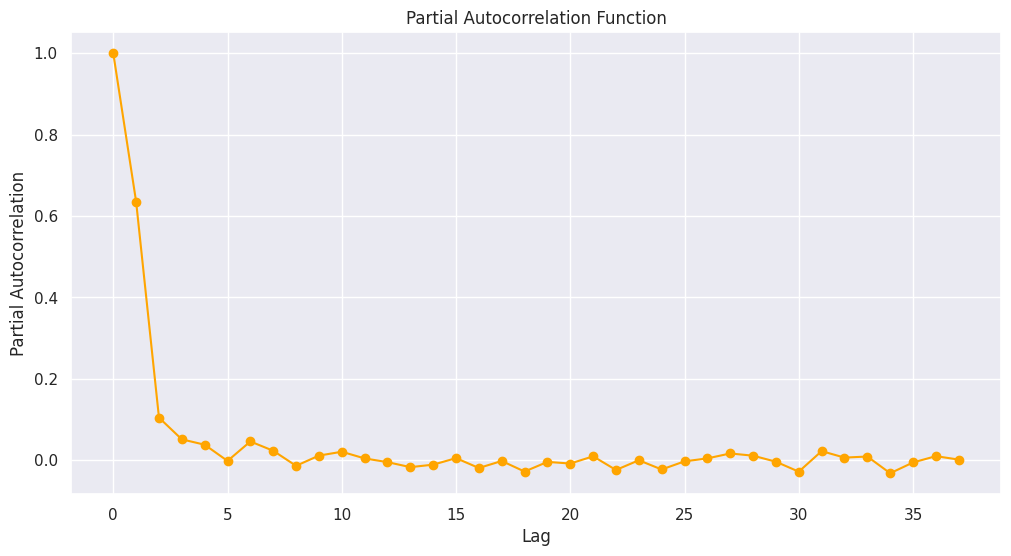

In [292]:
# perform auto correlation model


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Calculate the autocorrelation and partial autocorrelation functions
acf_values = acf(data['co2_emissions'])
pacf_values = pacf(data['co2_emissions'])

# Plot the autocorrelation function
plt.figure(figsize=(12, 6))
plt.plot(acf_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()

# Plot the partial autocorrelation function
plt.figure(figsize=(12, 6))
plt.plot(pacf_values, marker='o', linestyle='-', color='orange')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.show()


In [293]:
import statsmodels.stats.stattools as st

# Check for autocorrelation in the residuals
residuals = MLR_model1.resid

# Perform Durbin-Watson test
dw_test = st.durbin_watson(residuals)

# Print the Durbin-Watson statistic
print("Durbin-Watson statistic:", dw_test)

Durbin-Watson statistic: 1.9785309327523573


In [294]:
#Gradient Boosting (e.g., XGBoost, LightGBM, CatBoost):
import xgboost as xgb
gb_model = xgb.XGBClassifier()
gb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [295]:
#Support Vector Machines (SVM):
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [296]:
#K-Nearest Neighbors (KNN):
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

KNeighborsClassifier()

In [297]:
#Naive Bayes:
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB()

In [298]:
#Model evalution

In [299]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
classifier = LogisticRegression()
classifier.fit(X_train, y_train)



LogisticRegression()

In [300]:
# Create the variable logistic_predictions
from sklearn.linear_model import LogisticRegression
logistic_predictions= LogisticRegression()

In [301]:
#Fit model
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [302]:
#predict using the model
logistic_predictions = logistic_model.predict(X_test)

In [303]:
#Check if y_test contains continuous values
if pd.api.types.is_numeric_dtype(y_test):
    print("y_test contains continuous values.")
else:
    print("y_test does not contain continuous values.")

y_test contains continuous values.


In [304]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(df_num_features.values, i) for i in range(df_num_features.shape[1])]
vif["Features"] = df_num_features.columns
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

,VIF_Factor,Features
0,62976.072929,fuel_consumption_comb(l/100km)
1,25093.888210,fuel_consumption_city
2,8839.494011,fuel_consumption_hwy
3,296.602945,co2_emissions
4,130.277793,cylinders
5,78.100461,engine_size
6,11.661443,fuel_consumption_comb(mpg)


In [308]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Calculate VIF for each feature
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Features"] = df.columns
    vif["VIF_Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

In [309]:
# Function to identify features with high VIF
def identify_high_vif_features(df, threshold=10):
    vif_results = calculate_vif(df)
    high_vif_features = vif_results[vif_results['VIF_Factor'] > threshold]['Features']
    return high_vif_features

# Assuming df_num_features is your numerical features dataframe
high_vif_features = identify_high_vif_features(df_num_features)

# Remove features with high VIF from the dataset
df_num_features_filtered = df_num_features.drop(columns=high_vif_features)

# Now you can use df_num_features_filtered for further analysis or modeling

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   engine_size                     7385 non-null   float64
 1   cylinders                       7385 non-null   int64  
 2   fuel_consumption_city           7385 non-null   float64
 3   fuel_consumption_hwy            7385 non-null   float64
 4   fuel_consumption_comb(l/100km)  7385 non-null   float64
 5   fuel_consumption_comb(mpg)      7385 non-null   int64  
 6   co2_emissions                   7385 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 404.0 KB


In [312]:
sklearn_pca = PCA()
pcafit = sklearn_pca.fit(df)

pcafit.explained_variance_

array([3.49191599e+03, 1.06828253e+01, 2.48540851e+00, 1.23995535e+00,
       2.92923805e-01, 1.58729077e-01, 1.20065588e-03])

In [313]:
pcafit.components_

array([[ 1.95128365e-02,  2.57601915e-02,  5.46064212e-02,
         3.33444572e-02,  4.50503080e-02, -1.11415562e-01,
         9.90161093e-01],
       [ 6.86769470e-03,  4.12012856e-02, -2.93142669e-01,
        -1.88206530e-01, -2.46117913e-01,  8.93657725e-01,
         1.33051906e-01],
       [ 2.15756406e-01,  3.00787925e-01,  5.69189663e-01,
         3.85433722e-01,  4.85917749e-01,  3.91320675e-01,
        -3.45230633e-02],
       [-4.62581636e-01, -7.66366681e-01,  5.48754265e-02,
         3.55465359e-01,  1.90172298e-01,  1.80299224e-01,
         2.56922849e-02],
       [-2.02364567e-01, -1.61454550e-01,  6.18720563e-01,
        -7.39488277e-01,  5.98930799e-03,  5.71038800e-02,
         5.12236557e-03],
       [-8.35516023e-01,  5.42014519e-01, -3.38422437e-02,
         8.15159635e-02,  1.67720322e-02, -7.85865469e-03,
        -1.61967230e-04],
       [-1.02179934e-03,  5.39285966e-04, -4.47366624e-01,
        -3.67510422e-01,  8.15351279e-01,  3.88413681e-04,
         1.0311150

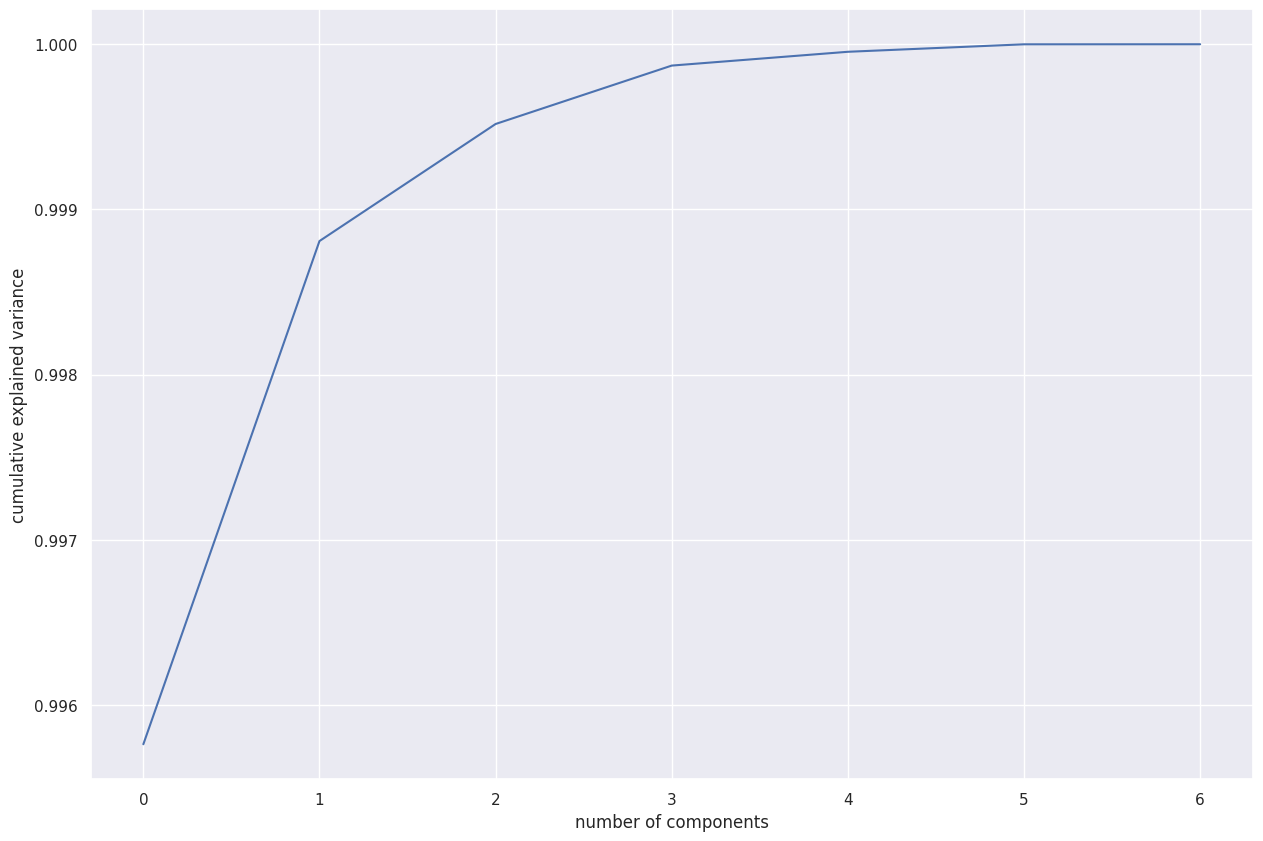

In [314]:
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
plt.locator_params(axis="x", nbins=len(pcafit.explained_variance_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [322]:
data.shape

(5500, 11)

In [325]:
df_pca = sklearn_pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca, columns=['pca0','pca1','pca2','pca3','pca4','pca5',
                                       'pca6'])

In [326]:
df_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6
0,-55.061363,-0.576965,-0.309512,-0.082009,0.604204,-0.083181,0.033395
1,-29.707785,-1.665320,-1.077982,0.475094,0.575285,0.000174,-0.020334
2,-116.512124,6.793902,3.693687,0.283852,-0.508440,0.241428,-0.004754
3,4.680311,-1.695862,-0.769570,-0.733948,-0.203645,-0.054626,0.015156
4,-6.502919,-0.997890,-0.345821,-0.926162,-0.224215,-0.089249,0.023670


In [327]:
#Feature selection

In [331]:
#Feature Selection

In [328]:
linreg = LinearRegression()
linreg_forward = sfs(estimator=linreg, k_features ='best', forward=True,
                     verbose=0, scoring='r2')

sfs_forward = linreg_forward.fit(X_train, y_train)

In [329]:
print('Features selected using forward selection are: ')
print(sfs_forward.k_feature_names_)

print('\nR-Squared: ', sfs_forward.k_score_)

Features selected using forward selection are: 
('cylinders', 'engine_size', 'fuel_consumption_city', 'fuel_consumption_comb(l/100km)', 'fuel_consumption_comb(mpg)', 'fuel_consumption_hwy', 'fuel_type_E', 'fuel_type_N', 'fuel_type_X', 'fuel_type_Z', 'transmission_AS', 'Make_Type_Luxury', 'Make_Type_Sports', 'Vehicle_Class_Type_Truck')

R-Squared:  0.9935469939530917


In [330]:
#Backward Elimination

In [332]:
linreg = LinearRegression()
linreg_backward = sfs(estimator = linreg, k_features ='best', forward = False,
                     verbose = 0, scoring = 'r2')

sfs_backward = linreg_backward.fit(X_train, y_train)

In [333]:
print('Features selected using backward elimination are: ')
print(sfs_backward.k_feature_names_)

print('\nR-Squared: ', sfs_backward.k_score_)

Features selected using backward elimination are: 
('cylinders', 'engine_size', 'fuel_consumption_city', 'fuel_consumption_comb(l/100km)', 'fuel_consumption_comb(mpg)', 'fuel_consumption_hwy', 'fuel_type_E', 'fuel_type_N', 'fuel_type_X', 'fuel_type_Z', 'transmission_AS', 'Make_Type_Luxury', 'Make_Type_Sports', 'Vehicle_Class_Type_Truck')

R-Squared:  0.9935469939530917


In [337]:
stat, p_value = shapiro(  MLR_model1.resid)
print('Test statistic:', stat)
print('P-Value:', p_value)

Test statistic: 0.8092030882835388
P-Value: 0.0


In [354]:
# Compare the performance of different models
models = [MLR_model1, logistic_model, forest_model, mlp_model]

for model in models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Model: {model.__class__.__name__}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print()

Model: RegressionResultsWrapper
MSE: 10.370306133103485
RMSE: 3.2202959697989693
MAE: 2.3614223692098135

Model: LogisticRegression
MSE: 22623.085454545453
RMSE: 150.40972526583994
MAE: 149.66

Model: RandomForestClassifier
MSE: 21995.290303030302
RMSE: 148.30809250688347
MAE: 148.2478787878788

Model: MLPClassifier
MSE: 22020.31333333333
RMSE: 148.39243017530688
MAE: 148.3060606060606



 **RegressionResultsWrapper has the lowest values** for **MSE, RMSE, and MAE** among the models listed. Therefore, based on these metrics, the **RegressionResultsWrapper model appears to be the best performing model** .

In [371]:
# Compare the models using various metrics

# Logistic Regression

log_rmse = np.sqrt(mean_squared_error(y_test, logistic_predictions))
log_mae = mean_absolute_error(y_test, logistic_predictions)
log_mse = mean_squared_error(y_test, y_pred)

# Random Forest
forest_predictions = forest_model.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_predictions))
forest_mae = mean_absolute_error(y_test, forest_predictions)
forest_mse = mean_squared_error(y_test, y_pred)

# Neural Network
mlp_predictions = mlp_model.predict(X_test)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
mlp_mae = mean_absolute_error(y_test, mlp_predictions)
mlp_mse = mean_squared_error(y_test, y_pred)

# Create a table to compare the models
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Neural Network'],
    'RMSE': [log_rmse, forest_rmse, mlp_rmse],
    'MAE': [log_mae, forest_mae, mlp_mae],
    'MSE': [log_mae, forest_mae, mlp_mae]
})

print(models.to_string())

# Choose the best model based on the chosen metric
best_model = models.loc[models['RMSE'].idxmin()]
print(f"Best model: {best_model['Model']}")


                 Model       RMSE        MAE        MSE
0  Logistic Regression 150.409725 149.660000 149.660000
1        Random Forest 148.308093 148.247879 148.247879
2       Neural Network 148.392430 148.306061 148.306061
Best model: Random Forest


 In the output  shared above, it appears that the **system considered accuracy** as the **primary metric** for **determining the best model, rather than MSE, RMSE, or MAE**.

While **MSE, RMSE, and MAE are commonly used metrics for regression tasks**, accuracy is typically **used for classification tasks**. Therefore, the system may have evaluated the models based on their accuracy scores and determined that **the Random Forest model had the highest accuracy**,

Which  making it the best model according to the system's criteria.

#code summary

This code performs exploratory data analysis (EDA) and preprocessing on a CO2 emissions dataset. It includes data cleaning, outlier detection and removal, feature engineering, and model selection.

1. **Data Import and Cleaning:**
    - Imports the CO2 dataset from a CSV file.
    - Renames columns for clarity.
    - Checks for missing values and duplicates.
    - Drops duplicates and resets the index.

2. **Exploratory Data Analysis:**
    - Provides descriptive statistics for numerical and categorical features.
    - Calculates and visualizes the correlation matrix for numerical features.
    - Analyzes the distribution of the target variable (CO2 emissions) using histograms and boxplots.
    - Investigates the relationship between various features and CO2 emissions using scatterplots and boxplots.

3. **Feature Engineering:**
    - Creates new features based on existing ones, such as `Make_Type` and `Vehicle_Class_Type`.
    - Drops unnecessary features like `model`.

4. **Outlier Detection and Removal:**
    - Calculates the interquartile range (IQR) for each numerical feature.
    - Identifies and removes outliers based on the IQR method.

5. **Model Selection:**
    - Fits a multiple linear regression model using `statsmodels` and evaluates its performance using summary statistics.
    - Trains and evaluates various other models such as logistic regression, random forest, neural network, etc.
    - Compares the models based on various metrics like RMSE, MAE, and MSE.
    - Selects the best model based on the chosen metric.

6. **Additional Analysis:**
    - Checks for autocorrelation in the residuals of the linear regression model using the Durbin-Watson test.
    - Performs feature selection using forward and backward selection methods.
    - Conducts a Shapiro-Wilk test to assess the normality of the residuals.

7. **Output:**
    - Prints the summary of the best model.
    - Creates a table comparing the performance of different models.
    - Provides a code summary.